# E-Commerce: Product Range Analysis

## Introduction

Our task is to analyze the product range of an online store that sells household goods.

We'll identify the top-selling products, determine if seasonality affects sales, and more.

By doing so, we'll allow the owners to make better decisions, which will ultimately lead to more revenue, better product selection, and a better user experience.

### Description of the data

The dataset contains the transaction history of an online store that sells household goods.

The file `ecommerce_dataset_us.csv` contains the following columns:

`InvoiceNo` — order identifier

`StockCode` — item identifier

`Description` — item name

`Quantity`

`InvoiceDate` — order date

`UnitPrice` — price per item

`CustomerID`

<h1>Tables Of Contents <a class="anchor" id="table_of_contents"></a></h1>

- [1. Study the genereal information](#info)
- [2. Data preprocessing](#pre)
- [3. Exploratory data analysis](#eda)
- [4. Market basket analysis](#basket)
- [5. Testing hypotheses](#test)
- [6. Final conclusion](#conclusion)
- [7. Link to dashboard](#links)
- [8. Resources](#re)

## Load the data file and study the general information.

<a class="anchor" id="info"></a>
[Go back to the Table of Contents](#table_of_contents)

In [1]:
# !pip install -Uq plotly
# !pip install sidetable -U
# !pip install -U seaborn
# pip install mlxtend

Import libraries:

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from datetime import datetime
import sys
import warnings
import sidetable
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Load data file to variable `ecommerce_data`: 

In [3]:
try:
    ecommerce_data = pd.read_csv('ecommerce_dataset_us.csv', sep="\t")
except:
    ecommerce_data = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep="\t")

In [4]:
# ignore 'FutureWarning'
if not sys.warnoptions:
       warnings.simplefilter("ignore")

Let's write a function to automate the initial study of the genenral information of the dataset:

In [5]:
def study_general_info(dataframe):
    '''
    This function provides us general information about a dataframe:
    - Random ten rows of the df.
    - Info about dataframe length, number of columns, columns' data type, memory usage.
    - Info about missing values and duplicates.
    - Basic statistical information about the dataframe.
    
    @param dataframe: The dataframe we want to study.
    @return: does not return anything, instead, print the information mentioned above.
    '''
    
    # print the random 10 rows of the dataframe
    print('\033[1m' + 'Random ten rows of the dataset:' + '\033[0m')
    display(dataframe.sample(10))
    print()
    
    # use info() method to check columns' data types
    print('\033[1m' + 'General info:' + '\033[0m')
    display(dataframe.info())
    print()
    
    # calculate number of missing values and their share of the column's values
    print('\033[1m' + 'Missing values:' + '\033[0m')
    display(dataframe.stb.missing(style=True))
    print()
    
    # find out if there are duplicates in the dataframe
    duplicates_cnt = dataframe.duplicated().sum()
    print('\033[1m' + 'Duplicates:' + '\033[0m')
    
    if duplicates_cnt > 0:
        print('Number of duplicates rows in the data is: {}'.format(duplicates_cnt))
    else:
        print('No duplicates found')
    print()
    
    # print the basic statistical info of the data
    print('\033[1m' + 'Basic statistical information:' + '\033[0m')
    display(dataframe.describe())

Apply the function above to `ecommerce_data`:

In [6]:
study_general_info(ecommerce_data)

Random ten rows of the dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
540998,581492,22730,ALARM CLOCK BAKELIKE IVORY,1,12/07/2019 10:03,7.46,NaN
242145,558315,22070,SMALL RED RETROSPOT MUG IN BOX,6,06/26/2019 11:44,3.75,15065.0
139046,548260,22995,TRAVEL CARD WALLET SUKI,2,03/28/2019 11:18,0.42,15373.0
196196,553831,23091,ZINC HERB GARDEN CONTAINER,3,05/17/2019 11:36,6.25,14442.0
46564,540355,22088,PAPER BUNTING COLOURED LACE,4,01/04/2019 15:11,4.21,NaN
304770,563613,21245,GREEN POLKADOT PLATE,24,08/16/2019 08:49,1.69,12688.0
330560,565919,23198,PANTRY MAGNETIC SHOPPING LIST,3,09/05/2019 16:48,3.29,NaN
303604,563549,22309,TEA COSY RED STRIPE,1,08/15/2019 12:34,4.96,NaN
68672,541871,22178,VICTORIAN GLASS HANGING T-LIGHT,2,01/22/2019 09:41,2.46,NaN
517006,580025,22662,LUNCH BAG DOLLY GIRL DESIGN,1,11/29/2019 11:53,1.65,15021.0



General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


None


Missing values:


,missing,total,percent
CustomerID,"135,080","541,909",24.93%
Description,"1,454","541,909",0.27%
InvoiceNo,0,"541,909",0.00%
StockCode,0,"541,909",0.00%
Quantity,0,"541,909",0.00%
InvoiceDate,0,"541,909",0.00%
UnitPrice,0,"541,909",0.00%



Duplicates:
Number of duplicates rows in the data is: 5268

Basic statistical information:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Upon reviewing the general information of `ecommerce_data`, several issues immediately come to mind:

- The columns' names do not comply with Python programming convention.


- `InvoiceDate` column's data type should be DateTime instead of an object.


- There are a lot of missing values in the 'CustomerId' and some in the 'Description' columns.


- There are 5,268 duplicates in the data.


- There are negative values in columns `Quantity` and `UnitPrice`, probably due to a technical issue. Moreover, based on the info provided by the describe() method, we can tell that there are outliers in these columns as well.

We'll address those issues in the next part of our analysis.

## Data preprocessing.

<a class="anchor" id="pre"></a>
[Go back to the Table of Contents](#table_of_contents)

First of all, let's rename `ecommerce_data` columns so they would comply with Python programming conventions:

In [7]:
ecommerce_data.columns = ['invoice_no', 'stock_code', 'description', 'quantity',
                          'invoice_date', 'unit_price', 'customer_id']

Second, we'll convert the data types of the `invoice_date` column:

In [8]:
# conver the `invoice_date` column to datetime data type
ecommerce_data['invoice_date'] = ecommerce_data['invoice_date'].astype('datetime64')

Next, we'll deal with the missing values in columns `customer_id` and `description`.

Earlier, we found 1,454 missing values in the `description` column which account for less than 0.3% of the data.

Potentially, we could try to fill those missing values by using values in `stock_code` (for each row with missing value in `description`, look for a rows with matching `stock_code` and take the description value with most instances).

But, since the share of those missing values is very small, we'll simply drop the rows with the missing values in `description` from the data.

With `customer_id` column, we got a different story, almost a quarter of the values in this columns are missing. In this case, we don't see a pattern or dependence on other columns that might provide a hint to fill in those missing values. 

So, we'll fill the missing values with 'unknown'.

In [9]:
# drop rows with missing values in `description` from the data
ecommerce_data.dropna(subset=['description'], inplace=True)

# reset the index
ecommerce_data.reset_index(drop=True, inplace=True)

# fill missing values in `customer_id` with 'unknown'
ecommerce_data['customer_id'].fillna('unknown', inplace=True)

Now, let's deal with the duplicates found in the data:

Before, we delete the duplicates, let's investigate them a little bit.

In [10]:
# print the first 10 duplicated rows
ecommerce_data[ecommerce_data.duplicated()].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2018-11-29 11:45:00,1.25,17908.0
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2018-11-29 11:45:00,2.10,17908.0
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2018-11-29 11:45:00,2.95,17908.0
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2018-11-29 11:45:00,4.95,17908.0
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2018-11-29 11:49:00,2.95,17920.0
587,536412,22273,FELTCRAFT DOLL MOLLY,1,2018-11-29 11:49:00,2.95,17920.0
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2018-11-29 11:49:00,3.75,17920.0
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,2018-11-29 11:49:00,2.10,17920.0
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2018-11-29 11:49:00,1.65,17920.0
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,2018-11-29 11:49:00,3.75,17920.0


Interesting, these rows aren't actually duplicates. Yes, some rows have identical values, but only in columns where it makes sense, such as `invoice_no`, `invoice_date`, and `customer_id`.

The other columns have different values, so we cannot treat these rows as duplicates, so we'll leave them as they are.

Last, we'll deal with the negative values from *quantity*, and *unit_price*.

Obviously, these negative values aren't possible. A quantity or price cannot be negative. There has probably been a mistake during input or preprocessing of the data, and these values should be positive (the absolute value of each negative value).

Before we take any action, let's investigate these values:

In [11]:
# print all the rows where `unit_price` is negative
display(ecommerce_data[(ecommerce_data['unit_price'] < 0)])

# print all the rows where `quantity` is negative
display(ecommerce_data[(ecommerce_data['quantity'] < 0)])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
298874,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,unknown
298875,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,unknown


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
...,...,...,...,...,...,...,...
538995,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397.0
540087,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498.0
540261,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311.0
540262,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315.0


Notice, that all the rows with the negative values in `quantity`/`unit_price` contain a letter in the `invoice_no` value.

- For rows with negative values in `quantity` there is a 'C' letter before the numbers in `invoice_no`. Perhaps this 'C' stands for orders that were canceled, that would explain the negative value in quantity, because the products were returned.

- For rows with negative values in `quantity` there is a 'A' letter before the numbers in `invoice_no`, and the description values are 'Adjust bad debt'.

Investigating these negative values, we realize they aren't a technical error, but a way to mark order cancellations and adjustments. Since we are only interested in products that were sold, we will drop these rows from our analysis.  

In [12]:
ecommerce_data = ecommerce_data.loc[
        (ecommerce_data['quantity'] > 0) & (ecommerce_data['unit_price'] > 0)].reset_index(drop=True)

### Conclusion

In conclusion, upon reviewing the general information of ecommerce_data, we found several issues that needed to be addressed.

So at this step, we done the following:
- Changed the columns' names so they'll comply with Python programming convention.


- `InvoiceDate` column's data type was coverted from `object` to `datetime`.


- We dropped the rows with missing values in `description`.


- Filled the missing values in `customer_id` with the value 'unknown'.


- We dropped the rows with the negative values in columns `quantity`, and `unit_price`. These rows probably represented orders' cancellations/adjustments that aren't relevant to our analysis.

A probable explanation for these issues is that something went wrong during the input/preprocess of the data.

## Exploratory data analysis

<a class="anchor" id="eda"></a>
[Go back to the Table of Contents](#table_of_contents)

In this step, we'll investigate the data further, ask questions, and plot graphs. We do this to better understand the data in front of us and to generate initial hypotheses.

### Study the distributions of the numerical data, plot histograms for Quantity, and UnitPrice. Are there outliers or anomalies in the data?

First, let's write a function to automate the process of plotting a histogram:

In [13]:
def plot_hist(dataframe, column):
    '''
    This function plot a frequency histogram 
    of a column of choice in a data frame.
    
    @param dataframe: The dataframe from which we want to plot the histogram.
    @param column: The column for the x axis of the histogram.
    
    @return: does not return anything, instead, plot a histogram.
    '''
    # plot a histogram using plotly express library
    fig = px.histogram(dataframe, x=column)

    # set title and x/y labels
    fig.update_layout(
        title= 'Distribution of ' + column,
        xaxis_title= column,
        yaxis_title= 'Frequency')
    fig.show()

Let's plot distribution histograms for `quantity` and `unit_price`:

In [ ]:
# call plot_hist function on `quantity`
plot_hist(ecommerce_data, 'quantity')

In [ ]:
# call plot_hist function on `unit_price`
plot_hist(ecommerce_data, 'unit_price')

Both distributions are heavily right skewed, we can see outliers on each distribution. Perhaps, these orders are commercial orders, and that's why they seem ridiculous for one person to buy.

For more informative insights, we will have to filter out these outliers, then plot the histograms again.

Let's write a function to determine outliers limits in a column:

In [16]:
def determine_outliers(column):
    '''
    This function calculate the outliers' limits of a column.
    The calculation is based on the formulas (Q1 - 1.5 * IQR), and (Q3 + 1.5 * IQR).
    
    @param column: The column from which we want to calculate outliers' limits

    @return: return lower and upper limits
    '''
    Q1, Q3 = np.percentile(column, [25,75])
    IQR = Q3 - Q1
    lower_lim = Q1 - (1.5 * IQR)
    upper_lim = Q3 + (1.5 * IQR)
    
    return lower_lim, upper_lim

Now, let's use the function to filter the outliers out of the data:

In [17]:
# list of columns we suspected to contain outliers
columns_with_outliers = ['quantity', 'unit_price']

# create a new df
filtered_ecommerce_data = ecommerce_data

# loop through each 'suspected' column and set limits with the function 'determine_outliers'
# then filter the dataframe with each tuple of limits for each feature

for column in columns_with_outliers:
    # set limits
    limits = determine_outliers(filtered_ecommerce_data[column])
    # apply filters
    filtered_ecommerce_data = filtered_ecommerce_data.loc[
        (filtered_ecommerce_data[column] >= limits[0]) & (filtered_ecommerce_data[column] <= limits[1])].reset_index(drop=True)

Let's calculate how much data we lost after the filtering:

In [18]:
print('Percentage of data lost after removing outliers: {:.2%}'.format(1 - (len(filtered_ecommerce_data)/len(ecommerce_data))))

Percentage of data lost after removing outliers: 16.49%


We lost 16.49% of our data. It's a significant amount but, if we kept those outliers they would skew our result significantly.

If our assumption before is correct (outliers are commercial orders), then they wouldn't benefit us anyway, since we are focusing on 'normal' orders.

Next, let's plot the histograms again, now with the filtered data:

In [ ]:
# call plot_hist function on `quantity`
plot_hist(filtered_ecommerce_data, 'quantity')

**Conclusions from the `quantity` histogram:**
- The distribution of quantity is still right-skewed, but not as extreme as before the filtering.


- The most frequent quantity is '1' with almost 130K instances.


- Even numbers of quantity have significantly more instances than odd numbers. This can be contributed to sales/discounts. Sales/discounts will likely include an even number of products rather than odd.

In [ ]:
# call plot_hist function on `unit_price`
plot_hist(filtered_ecommerce_data, 'unit_price')

**Conclusions from the `unit_price` histogram:**

- The distribution of unit prices is still right-skewed, but not as extreme as before the filtering.


- A unit's price range is between 0.08 to 8.5.


- Customers tend to buy relatively cheap (price between 0.08 to 4) products than the pricer ones (5 to 8).

### When do people most often purchase online?

Let's plot a histogram to investigate the distribution of orders in terms of dates:

In [ ]:
plot_hist(filtered_ecommerce_data, 'invoice_date')

**Conclusions from the `unit_price` histogram:**
- The most active period for orders was September to December, the Autumn season (if we're talking about the Northern Hemisphere). Compared to the rest of the year, we notice a significant increase in orders during these months.


- There is a gap between December 23 and January 1, when no orders were placed. There is a possibility that the owners of the store decided to take a Christmas and New Year's Eve vacation, which would prevent the store from accepting orders.

In the autumn, we have big sales events in the ecommerce sector, such as Black Friday, Cyber Monday, holiday sales and so on. Consequently, our store is busier in the Autumn as well.

Next, what time of day do people buy more often? let's plot a histogram to show the distribution:

In [ ]:
# create a new column to contain the hour of the day value for each order
filtered_ecommerce_data['hour_of_day'] = filtered_ecommerce_data['invoice_date'].dt.hour

# plot a histogram
plot_hist(filtered_ecommerce_data, 'hour_of_day')

The majority of online orders occur between 12pm and 3pm, during lunchtime.

### How many items does a customer purchase per order?

Let's plot a histogram of the items per order distribution:

In [23]:
# aggregate thr number of items per order
items_per_order = filtered_ecommerce_data.groupby('invoice_no', as_index=False)['quantity'].sum()

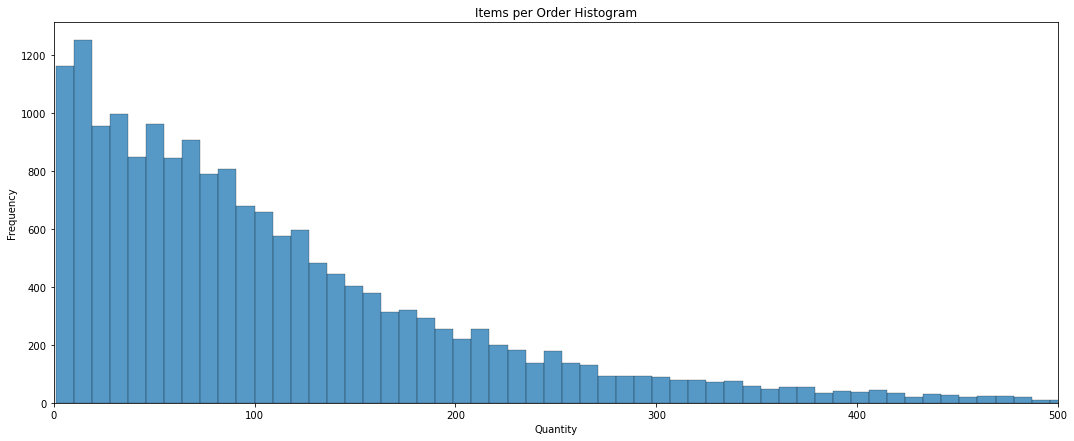

In [24]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

ax = sns.histplot(items_per_order['quantity'])

#set title and x/y labels
plt.title('Items per Order Histogram')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

# set axis limit
ax.set(xlim=(0, 500))

plt.show()

The distribution is right-skewed, probably due to wholesale customers who order a large number of products that the 'regular' customer won't. The majority of customers ordered between 1 and 70 items.

### What's the average order size?

First, let's create a new column called `revenue` (`quantity` * `unit_price`), this will allow us to calculate average order size:

In [25]:
# for each row , calculate the revenue (`quantity` * `unit_price`)
filtered_ecommerce_data['revenue'] = filtered_ecommerce_data['quantity'] * filtered_ecommerce_data['unit_price']

In [26]:
# aggregate the revenue for each order
avg_order_size = filtered_ecommerce_data.groupby('invoice_no', as_index=False)['revenue'].sum()

# print the average order size
print('The average order size is: {:.2f}'.format(avg_order_size['revenue'].mean()))

The average order size is: 270.20


270.2 is the average order size.

Let's see the distribution of order sizes:

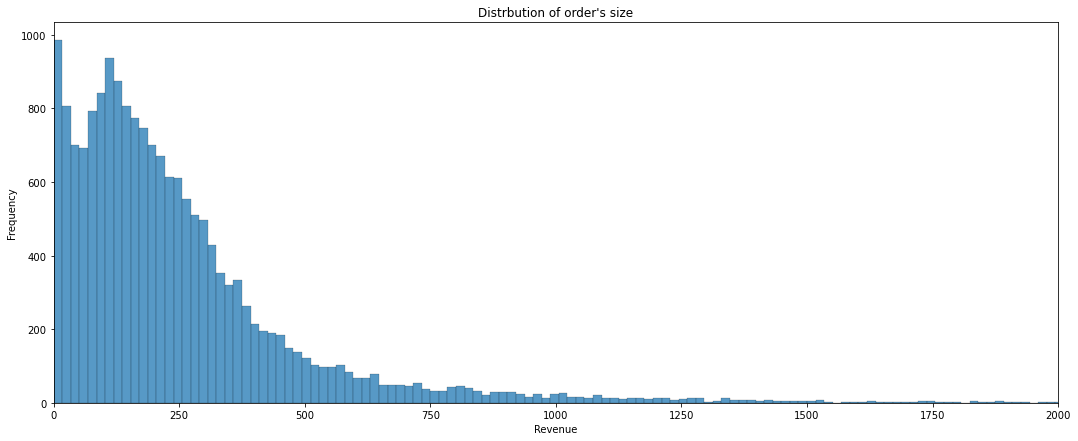

In [27]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

ax = sns.histplot(avg_order_size['revenue'])

#set title and x/y labels
plt.title("Distrbution of order's size")
plt.xlabel('Revenue')
plt.ylabel('Frequency')

# set axis limit
ax.set(xlim=(0, 2000))

plt.show()

Right-skewed distribution. Most of our customers' orders size don't exceed 350.

### What are the top 10 bestsellers?

In [28]:
# aggregate the top 10 best-sellers items by the number of orders (not absolute quantity)
top_10_best = filtered_ecommerce_data.groupby(
    'description', as_index=False)['quantity'].count().sort_values('quantity', ascending=False).head(10)

Let's plot a bar chart to visualize the top ten best-sellers items in the store:

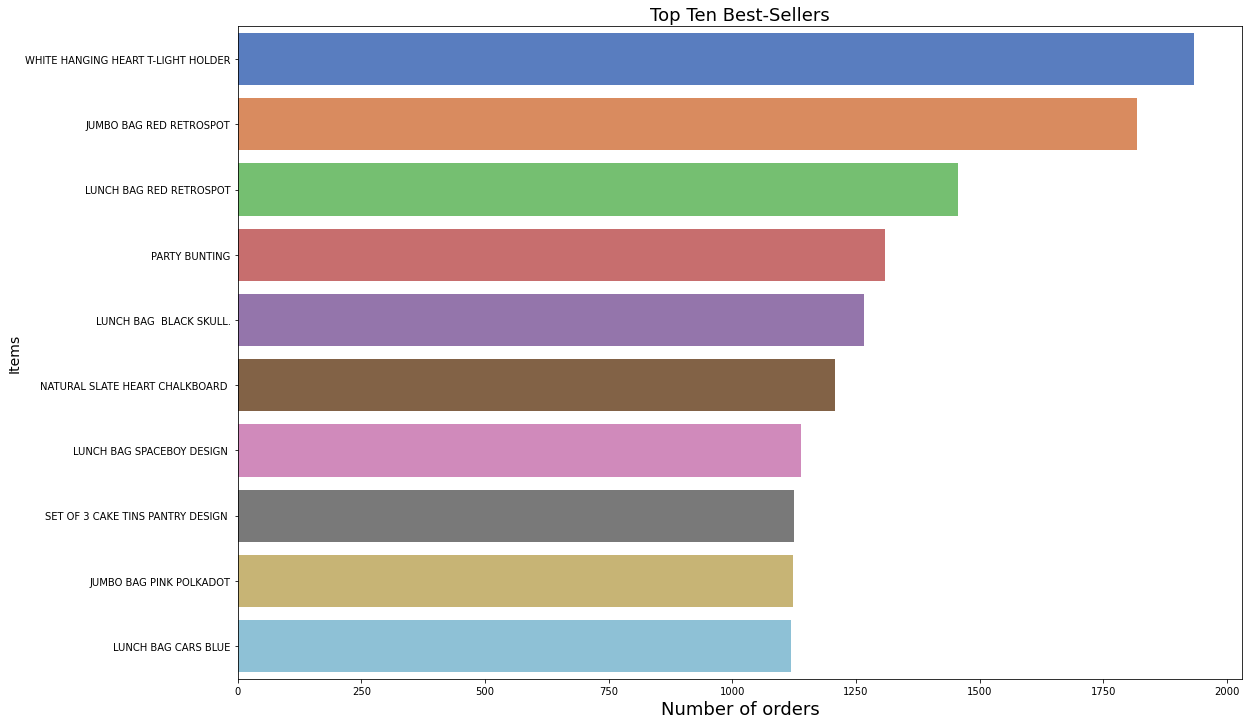

In [29]:
# set figure size for the graph 
plt.figure(figsize=(18, 12))

# plot a horizontal bar chart to show the top 10 sellers
ax = sns.barplot(data=top_10_best, x='quantity', y='description', orient = 'h', palette='muted')

#set title and x/y labels
plt.title("Top Ten Best-Sellers", size=18)
plt.xlabel('Number of orders', size=18)
plt.ylabel('Items', size=14)

plt.show()

As these items are the top 10 best-sellers, they should continue to be sold at the store, since they are very popular with customers.

### Conclusion

To conclude, at first, we plotted histograms for the numerical columns (`quantity`, `unit_price`). We discovered a significant amount of outliers in both distributions.

After filtering the outliers out of the data, we plotted the histograms again and arrived at the following conclusions:

- Both distributions are still right-skewed, but not as extreme as before the filtering.


- The most frequent quantity is '1' with almost 130K instances.


- Even numbers of quantity have significantly more instances than odd numbers. This can be contributed to sales/discounts. Sales/discounts will likely include an even number of products rather than odd.


- A unit's price range is between 0.08 and 8.5.


- Customers tend to buy relatively cheap (price between 0.08 and 4) products than the pricer ones (5 to 8).

Next, we investigated when customers most often make a purchase. Here are the facts:

- The most active period for orders was September to December, the Autumn season (if we're talking about the Northern Hemisphere). Compared to the rest of the year, we notice a significant increase in orders during these months.


- There is a gap between December 23 and January 1, when no orders were placed. There is a possibility that the owners of the store decided to take a Christmas and New Year's Eve vacation, which would prevent the store from accepting orders.


- The majority of online orders occur between 12 pm and 3 pm, during lunchtime.

In the autumn, we have big sales events in the e-commerce sector, such as Black Friday, Cyber Monday, holiday sales, and so on. Consequently, our store is busier in the Autumn as well.

Next, we discovered:

- The majority of customers ordered between 1 and 70 items.


- The average order size is: 270.20

- Most of our customers' orders size doesn't exceed 350.

Lastly, we determined which items are the store's best-sellers. We visualized it using a horizontal bar chart.

## Market basket analysis.

<a class="anchor" id="basket"></a>
[Go back to the Table of Contents](#table_of_contents)

In this step, we'll determine which items are bought together often using the Apriori algorithm.

Market basket analysis is an application of association analysis which attempts to find common patterns of items in large data sets.

**A brief explanation of Association rules:**

Association rules are normally written like this: {Diapers} -> {Beer} which means that there is a strong relationship between customers that purchased diapers and also purchased beer in the same transaction.

In the above example, the {Diaper} is the antecedent and the {Beer} is the consequent. Both antecedents and consequents can have multiple items. In other words, {Diaper, Gum} -> {Beer, Chips} is a valid rule.

`Support`: is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

`Confidence`: is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

`Lift`: is the ratio of the observed support to that expected if the two rules were independent. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

This analysis requires that all the data for a transaction be included in 1 row and the items should be 1-hot encoded.

**Group the dataset by transactions (`invoice_no`), with products' names as columns (`description`). For each transaction, assign the value 1 if the product's name is in the transaction, for the rest assign the value 0.**

First, let's write the function for the one hot encoding of the data:

In [30]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [31]:
# remove extra spaces in the `description` column
filtered_ecommerce_data['description'] = filtered_ecommerce_data['description'].str.strip()

# groupby `invoice_no` as indices, 'description' as columns
# for each transaction, place the value 1 in the suitable column if the item was included in the transaction
# place 0 otherwise
market_basket = filtered_ecommerce_data.groupby(
    ['invoice_no', 'description'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('invoice_no')

# apply the function to the table above
basket_sets = market_basket.applymap(encode_units)

Now that the data is structured properly, we can generate frequent item sets that have a support of at least 3%:

In [32]:
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)

The final step is to generate the rules with their corresponding support, confidence and lift:

In [33]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
# print the first 5 rows
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.056342,0.052497,0.033883,0.601385,11.455678,0.030925,2.376987
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.052497,0.056342,0.033883,0.645435,11.455678,0.030925,2.661455
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038843,0.051605,0.031988,0.823529,15.958328,0.029984,5.374238
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.051605,0.038843,0.031988,0.619870,15.958328,0.029984,2.528498
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.052998,0.051605,0.038397,0.724501,14.039349,0.035662,3.442457


Let's filter the dataframe `rules`, look for a lift value above 3, and confidence level above 0.5:

In [34]:
# apply filters and sort by 'confidence' and 'lift'
rules[(rules['lift'] >= 4) & (rules['confidence'] >= 0.6)][[
    'antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(['confidence', 'lift'], ascending=False)

,antecedents,consequents,support,confidence,lift
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031988,0.823529,15.958328
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038397,0.744060,14.039349
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038397,0.724501,14.039349
7,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.040515,0.659710,6.591219
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.033883,0.645435,11.455678
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031988,0.619870,15.958328
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.033883,0.601385,11.455678


### Conclusion

To conclude, the following pairs of items are frequently bought together, and should be included in each other recommended items:

1. `PINK REGENCY TEACUP AND SAUCER` and `GREEN REGENCY TEACUP AND SAUCER`.


2. `GREEN REGENCY TEACUP AND SAUCER` and `ROSES REGENCY TEACUP AND SAUCER`.


3. `JUMBO BAG PINK POLKADOT` and `JUMBO BAG RED RETROSPOT`.


4. `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED`.

## Testing hypotheses.

<a class="anchor" id="test"></a>
[Go back to the Table of Contents](#table_of_contents)

### Does the average purchase size differ between Autumn and Summer?

First, we need to sort transactions according so seasons. We'll write a function that will assign a season to each transactions in our data.

**Note:** We'll determine the seasons range according to the Northern Hemisphere.

In [35]:
def determine_season(row):
    '''
    This function returns the season in which an order was placed.
    
    @param row: The row representing the order.

    @return: the season in which an order was placed.
    '''   
    month = row['invoice_date'].month
    day = row['invoice_date'].day

    if month in (1, 2, 3):
        season = 'winter'
    elif month in (4, 5, 6):
        season = 'spring'
    elif month in (7, 8, 9):
        season = 'summer'
    else:
        season = 'autumn'

    if (month == 3) and (day > 19):
        season = 'spring'
    elif (month == 6) and (day > 20):
        season = 'summer'
    elif (month == 9) and (day > 21):
        season = 'autumn'
    elif (month == 12) and (day > 20):
        season = 'winter'
        
    return season

Now let's apply the function to our data:

In [36]:
filtered_ecommerce_data['season'] = filtered_ecommerce_data.apply(determine_season, axis=1)

Let's create our sample for the test:

In [37]:
# aggregate the revenue per order placed in the autumn
autumn_sample = filtered_ecommerce_data.query('season == "autumn"').groupby('invoice_no')['revenue'].sum()

# aggregate the revenue per order placed in the summer
summer_sample = filtered_ecommerce_data.query('season == "summer"').groupby('invoice_no')['revenue'].sum()

Next, let's formulate our hypothesis:

Average purchase size differ between Autumn and Summer.

In this case are null hypothesis would be:

- The average purchase size in the Autumn and Summer are the same.

And the alternative hypothesis would be:

- The average purchase size in the Autumn and Summer are the not same.

Before we test the hypothesis let's examine the differences between the samples average order size variance.

In [38]:
print('The variance of  autumn sample is {}'.format(np.var(autumn_sample)))
print('The variance of summer sample is {}'.format(np.var(summer_sample)))

The variance of  autumn sample is 194053.4173114105
The variance of summer sample is 102025.4797236797


We can see clearly that there is more than 5% differences between the variance values, that means we should use 'equal_var=False' when we test the hypothesis.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

In [39]:
alpha = 0.05  # critical statistical significance level

# if the p-value is less than alpha, we reject the hypothesis
results = st.ttest_ind(autumn_sample, summer_sample, equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.051652803153175594
We can't reject the null hypothesis


The null hypothesis can't be rejected, meaning, we can't say for sure if the average purchase size differ between Autumn and Summer.

### Does the average purchase size differ between new customers and regular customers?

First, we'll group `filtered_ecommerce_data` by known customers (`'customer_id != "unknown"'`), for each of them we'll count the number of unique orders he placed, and sum the total revenue he made for the store:

In [40]:
revenue_per_customer = filtered_ecommerce_data.query('customer_id != "unknown"').groupby(
    'customer_id')['invoice_no','revenue'].agg({'invoice_no' : pd.Series.nunique, 'revenue' : 'sum'})

Now, we'll calculate the average order size for  each customer:

In [41]:
revenue_per_customer['revenue_per_order'] = revenue_per_customer['revenue'] / revenue_per_customer['invoice_no']

Next, we'll split the data to two parts: new customers, or regular customers.

**Note:** We'll consider customers who ordered up to 2 times 'new', the rest will be 'regular'.

In [42]:
new_sample = revenue_per_customer.query('invoice_no <= 2')['revenue']

reg_sample = revenue_per_customer.query('invoice_no > 2')['revenue']

Next, let's formulate our hypothesis:

Average purchase size differ between new and regular customers.

In this case are null hypothesis would be:

- The average purchase size of new customer and regular customer are the same.

And the alternative hypothesis would be:

- The average purchase size of new customer and regular customer are not the same.

Before we test the hypothesis let's examine the differences between the samples average order size variance.

In [43]:
print('The variance of  new customers sample is {}'.format(np.var(new_sample)))
print('The variance of regular customers sample is {}'.format(np.var(reg_sample)))

The variance of  new customers sample is 84804.99229737616
The variance of regular customers sample is 7901305.045668643


We can see clearly that there is more than 5% differences between the variance values, that means we should use 'equal_var=False' when we test the hypothesis.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

In [44]:
alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(new_sample, reg_sample, equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  3.1892457164632273e-98
We reject the null hypothesis


As you can see above the null hypothesis was rejected which means that the average order size of new and regular customers are not equal.

### Conclusion

To conclude, at first we formulated the hypotheses.

**The first hypothesis:**
The average purchase size differs between Autumn and Summer.
Next, we stated the null and alternative hypotheses:
- H0, The average purchase size in the Autumn and Summer are the same.
- H1, The average purchase size in the Autumn and Summer are the not same.

**The second hypothesis:**
The average purchase size differs between new and regular customers.
Next, we stated the null and alternative hypotheses:
- H0, The average purchase size of new customers and regular customers is the same.
- H1, The average purchase size of new customers and regular customers is not the same.

For both hypotheses, we decided to use an alpha value of 0.05 since it's the 'golden standard' for testing the hypothesis.
Before we tested the hypotheses we examined the differences between the sample's variance.
In both cases the difference was bigger than 5%, therefore we used 'equal_var=False' in both t-tests.

Later we applied t-test to test both hypotheses and got the results:
- In the first hypothesis, the null hypothesis wasn't rejected.
- In the second hypothesis, the null hypothesis was rejected.

## Final conclusion

<a class="anchor" id="conclusion"></a>
[Go back to the Table of Contents](#table_of_contents)

In conclusion, upon reviewing the general information of `ecommerce_data`, several issues immediately came to mind:

- The columns' names do not comply with Python programming convention.


- `InvoiceDate` column's data type should be DateTime instead of an object.


- There are a lot of missing values in the 'CustomerId' and some in the 'Description' columns.


- There are 5,268 duplicates in the data.


- There are negative values in columns `Quantity` and `UnitPrice`, probably due to a technical issue. Moreover, based on the info provided by the describe() method, we can tell that there are outliers in these columns as well.

Later, in the preprocessing stage, we took the following steps:

- Changed the columns' names so they'll comply with Python programming convention.


- `InvoiceDate` column's data type was converted from `object` to `datetime`.


- We dropped the rows with missing values in `description`.


- Filled the missing values in `customer_id` with the value 'unknown'.


- We dropped the rows with the negative values in columns `quantity`, and `unit_price`. These rows probably represented orders' cancellations/adjustments that aren't relevant to our analysis.

A probable explanation for these issues is that something went wrong during the input/preprocess of the data.

Next, at the EDA stage, we plotted histograms for the numerical columns (`quantity`, `unit_price`). We discovered a significant amount of outliers in both distributions.

After filtering the outliers out of the data, we plotted the histograms again and arrived at the following conclusions:

- Both distributions are still right-skewed, but not as extreme as before the filtering.


- The most frequent quantity is '1' with almost 130K instances.


- Even numbers of quantity have significantly more instances than odd numbers. This can be contributed to sales/discounts. Sales/discounts will likely include an even number of products rather than odd.


- A unit's price range is between 0.08 and 8.5.


- Customers tend to buy relatively cheap (price between 0.08 and 4) products than the pricer ones (5 to 8).

Next, we investigated when customers most often make a purchase. Here are the facts:

- The most active period for orders was September to December, the Autumn season (if we're talking about the Northern Hemisphere). Compared to the rest of the year, we notice a significant increase in orders during these months.


- There is a gap between December 23 and January 1, when no orders were placed. There is a possibility that the owners of the store decided to take a Christmas and New Year's Eve vacation, which would prevent the store from accepting orders.


- The majority of online orders occur between 12 pm and 3 pm, during lunchtime.

In the autumn, we have big sales events in the e-commerce sector, such as Black Friday, Cyber Monday, holiday sales, and so on. Consequently, our store is busier in the Autumn as well.

Next, we discovered:

- The majority of customers ordered between 1 and 70 items.


- The average order size is: 270.20

- Most of our customers' orders size doesn't exceed 350.

Lastly, we determined which items are the store's best-sellers, we visualized it using a horizontal bar chart.

Later, we applied market basket analysis to determine which items are bought together often using the Apriori algorithm.

the following pairs of items are frequently bought together, and should be included in each other recommended items:

1. `PINK REGENCY TEACUP AND SAUCER` and `GREEN REGENCY TEACUP AND SAUCER`.


2. `GREEN REGENCY TEACUP AND SAUCER` and `ROSES REGENCY TEACUP AND SAUCER`.


3. `JUMBO BAG PINK POLKADOT` and `JUMBO BAG RED RETROSPOT`.


4. `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED`.

Next, we tested two hypotheses.

**The first hypothesis:**
Average purchase sizes differ between Autumn and Summer.
Next, we stated the null and alternative hypotheses:
- H0, The average purchase size in the Autumn and Summer are the same.
- H1, The average purchase size in the Autumn and Summer are the not same.

**The second hypothesis:**
Average purchase sizes differ between new and regular customers.
Next, we stated the null and alternative hypotheses:
- H0, The average purchase size of new customers and regular customers is the same.
- H1, The average purchase size of new customers and regular customers is not the same.

For both hypotheses, we decided to use an alpha value of 0.05 since it is the 'golden standard' for testing the hypothesis.
Before we tested the hypotheses we examined the differences between the sample's variance.
In both cases the difference was bigger than 5%, therefore we used 'equal_var=False' in both t-tests.

Later we applied t-test to test both hypotheses and got the results:
- In the first hypothesis, the null hypothesis wasn't rejected.
- In the second hypothesis, the null hypothesis was rejected.

## Dashboard link

<a class="anchor" id="links"></a>
[Go back to the Table of Contents](#table_of_contents)

Link to dashboard:

https://public.tableau.com/views/Dashboard-DailyPurchases/DailypurchasesDashboard?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Resources

<a class="anchor" id="re"></a>
[Go back to the Table of Contents](#table_of_contents)

1. https://www.dotactiv.com/blog/product-range-review - A blog post that helped me understand what is product range analysis and how to approach it.


2. https://medium.com/analytics-vidhya/in-technical-terms-apriori-used-in-the-market-basket-analysis-tries-to-find-out-which-items-are-78287911a4df - Blog post that introduced me to market basket analysis.


3. https://www-users.cse.umn.edu/~kumar001/dmbook/ch6.pdf - Explanation of the math behind association analysis.


4. http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/ - Documentation of the implementation of the Apriori algorithm within the mlxtend library.


5. https://plotly.com/python/ , https://seaborn.pydata.org/ , https://matplotlib.org/ - Documentation of visualization libraries that I used in the project, helped me to make some of my visualizations.